# IMDb Sentiment Classifier — SVM, Naive Bayes, Random Forest
This notebook builds and evaluates multiple classic machine learning models on the IMDb movie review dataset using TF-IDF features.

### Objectives:
- Load the cleaned dataset and TF-IDF features
- Train and evaluate:
  - Support Vector Machine (SVM)
  - Multinomial Naive Bayes (NB)
  - Random Forest Classifier (RF)
- Compare their performance with Logistic Regression

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

## Load Dataset & Prepare it

In [2]:
# Load the cleaned data that we did in 01_eda_preprocessing.ipynb
imdb_data_df = pd.read_csv('../data/imdb_clean.csv')
imdb_data_df.head()

,clean_review,sentiment
0,one reviewers mentioned watching oz episode ho...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake thinks zombie...,negative
4,petter mattei love time money visually stunnin...,positive


In [3]:
# Encoding labels to be 0 & 1 such that 1 represents positive and 0 represents negative
imdb_data_df['label'] = imdb_data_df['sentiment'].map({'positive':1, 'negative':0})
imdb_data_df

,clean_review,sentiment,label
0,one reviewers mentioned watching oz episode ho...,positive,1
1,wonderful little production filming technique ...,positive,1
2,thought wonderful way spend time hot summer we...,positive,1
3,basically family little boy jake thinks zombie...,negative,0
4,petter mattei love time money visually stunnin...,positive,1
...,...,...,...
49995,thought movie right good job creative original...,positive,1
49996,bad plot bad dialogue bad acting idiotic direc...,negative,0
49997,catholic taught parochial elementary schools n...,negative,0
49998,going disagree previous comment side maltin on...,negative,0


In [4]:
# Setting the Features and labels to X and y
X = imdb_data_df['clean_review']
y = imdb_data_df['label']

# Showing an example
print("Feature:", X[0])
print("Label:", y[0])

Feature: one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lack stre

In [5]:
# Splitting the data to Train-Test Split to be 80% Training data and 20% Testing data
# We set stratify to keep the label distribution balanced in both sets to ensure no bias
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Number of Training Samples:", len(X_train))
print("Number of Testing Samples:", len(X_test))

Number of Training Samples: 40000
Number of Testing Samples: 10000


## Feature Extraction Using TF-IDF
We use TF-IDF as in the previous notebook (02_vectorization_logreg) it showed that using TF-IDF is better than CountVectorizer for our data

In [6]:
# Initializing the TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))

# We apply to train data to learn vocabulary & computes TF-IDF values for train set
X_train_tfidf = tfidf.fit_transform(X_train)

# We apply same vocabulary & weights to the test set
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF train shape:", X_train_tfidf.shape)
print("TF-IDF test shape:", X_test_tfidf.shape)

TF-IDF train shape: (40000, 10000)
TF-IDF test shape: (10000, 10000)


### Visualize TF-IDF

In [7]:
# Getting the feature names
feature_names = tfidf.get_feature_names_out()

# Getting the average TF-IDF score across all
avg_tfidf_scores = X_train_tfidf.mean(axis=0).A1 

# Creating a dataframe with the term and score
tfidf_df = pd.DataFrame({'term': feature_names, 'score': avg_tfidf_scores})

# Viewing top 30 terms
top_30_terms = tfidf_df.sort_values(by='score', ascending=False).head(30)
top_30_terms


,term,score
5682,movie,0.048938
3079,film,0.042130
6229,one,0.027954
4958,like,0.023682
3723,good,0.020860
7144,really,0.017681
8455,story,0.017563
8985,time,0.017512
9875,would,0.017479
7770,see,0.017246


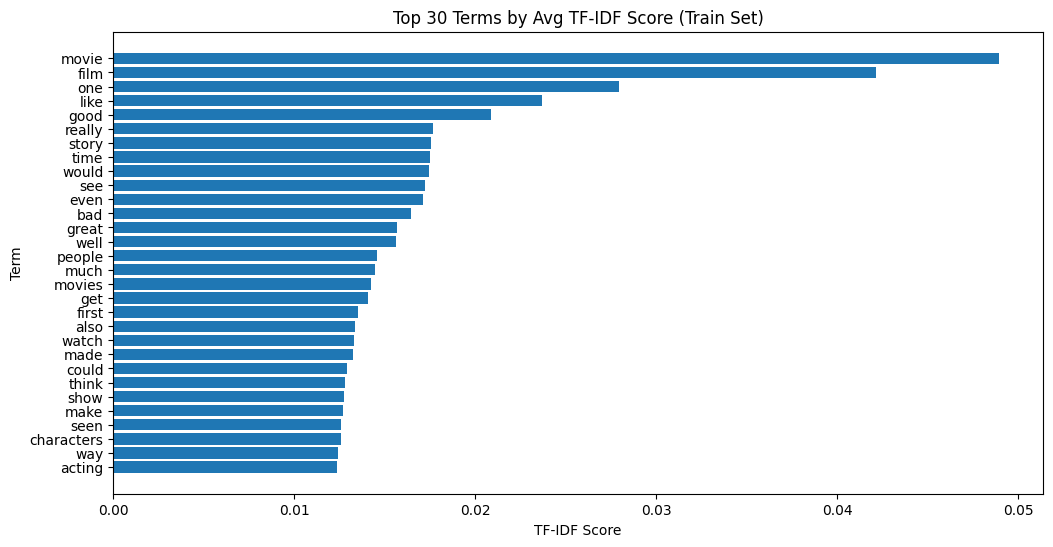

In [8]:
# Plotting top 30 terms
plt.figure(figsize=(12,6))
plt.barh(top_30_terms['term'][::-1], top_30_terms['score'][::-1])
plt.title("Top 30 Terms by Avg TF-IDF Score (Train Set)")
plt.xlabel("TF-IDF Score")
plt.ylabel("Term")
plt.show()

## Evaluate Model Function
This function trains the model, predicts on the test set, and displays training/test accuracy, classification report, and confusion matrix.

In [9]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    # Train the model
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    train_time = end - start
    
    print(f"Training Time: {train_time:.2f} seconds")
    
    # Predict on test set
    y_pred = model.predict(X_test)

    # Training Accuracy
    train_acc = model.score(X_train_tfidf, y_train)
    print(f"Training Accuracy: {train_acc*100:.2f} %")

    # Accuracy
    test_acc = accuracy_score(y_test, y_pred)
    print(f"{model_name} Test Accuracy: {test_acc*100:.2f}%\n")

    # Classification Report
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    labels = ['Negative', 'Positive']

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    return {
        "Model": model_name,
        "Train Accuracy": train_acc,
        "Test Accuracy": test_acc,
        "Training Time (s)": train_time
    }

## Model 1: Support Vector Machine (SVM)
Support Vector Machine (SVM) is a powerful linear classifier that tries to find the best hyperplane that separates the data into two classes. In text classification, it works well with high-dimensional, sparse features like TF-IDF.

We use LinearSVC, which is optimized for large-scale text classification.

Training Time: 1.29 seconds
Training Accuracy: 95.92 %
SVM (Linear SVC) Test Accuracy: 88.99%

Classification Report for SVM (Linear SVC):

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      5000
           1       0.89      0.89      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



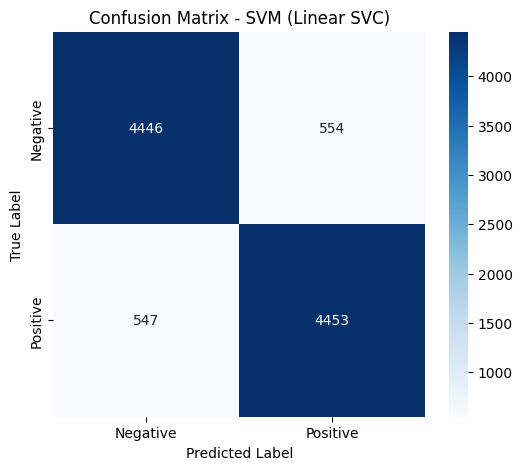

In [10]:
svm_model = LinearSVC()
svm_results = evaluate_model(svm_model, X_train_tfidf, y_train, X_test_tfidf, y_test, model_name="SVM (Linear SVC)")

In [11]:
def predict_sentiment(text):
    vectorized = tfidf.transform([text])
    prediction = svm_model.predict(vectorized)[0]
    return "Positive" if prediction == 1 else "Negative"

print(predict_sentiment("the movie was surprisingly amazing"))
print(predict_sentiment("this was the worst movie ever"))
print(predict_sentiment("i don't like this movie at all"))

Positive
Negative
Negative


## Model 2: Multinomial Naive Bayes
Naive Bayes is a probabilistic classifier based on Bayes' Theorem. It's particularly effective for text classification tasks where features represent word counts or frequencies.

We use MultinomialNB, which works well with discrete word frequencies (like TF-IDF or CountVectorizer).

Training Time: 0.02 seconds
Training Accuracy: 87.91 %
Multinomial Naive Bayes Test Accuracy: 86.76%

Classification Report for Multinomial Naive Bayes:

              precision    recall  f1-score   support

           0       0.88      0.85      0.87      5000
           1       0.86      0.88      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



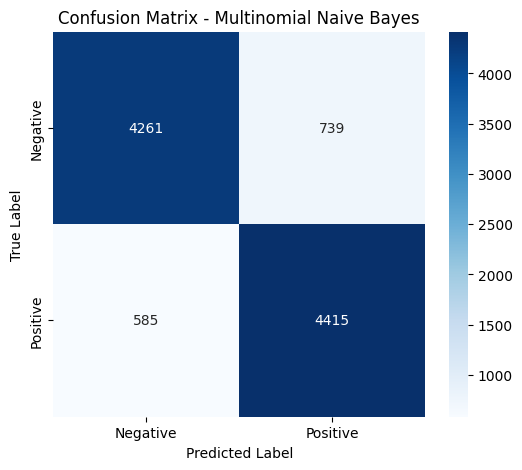

In [12]:
nb_model = MultinomialNB()
nb_results = evaluate_model(nb_model, X_train_tfidf, y_train, X_test_tfidf, y_test, model_name="Multinomial Naive Bayes")

In [13]:
def predict_sentiment(text):
    vectorized = tfidf.transform([text])
    prediction = nb_model.predict(vectorized)[0]
    return "Positive" if prediction == 1 else "Negative"

print(predict_sentiment("the movie was surprisingly amazing"))
print(predict_sentiment("this was the worst movie ever"))
print(predict_sentiment("i don't like this movie at all"))

Positive
Negative
Negative


## Model 3: Random Forest Classifier

Random Forest is an ensemble learning method that builds multiple decision trees and merges them together to get more accurate and stable predictions. It's powerful, but may not perform as well as linear models in sparse high-dimensional text data.

Training Time: 184.19 seconds
Training Accuracy: 100.00 %
Random Forest (RF) Test Accuracy: 86.01%

Classification Report for Random Forest (RF):

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      5000
           1       0.87      0.85      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



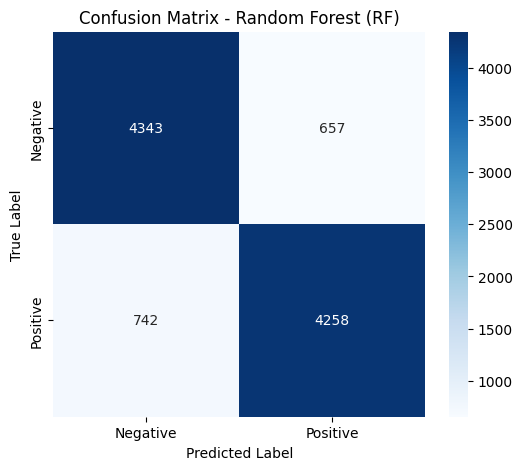

In [14]:
rf_model = RandomForestClassifier()
rf_results = evaluate_model(rf_model, X_train_tfidf, y_train, X_test_tfidf, y_test, model_name="Random Forest (RF)")

In [15]:
def predict_sentiment(text):
    vectorized = tfidf.transform([text])
    prediction = rf_model.predict(vectorized)[0]
    return "Positive" if prediction == 1 else "Negative"

print(predict_sentiment("the movie was surprisingly amazing"))
print(predict_sentiment("this was the worst movie ever"))
print(predict_sentiment("i don't like this movie at all"))

Positive
Negative
Positive


## Summary and Comparison

In [17]:
import pandas as pd

model_summary = pd.DataFrame([
    {"Model": "Logistic Regression", "Train Accuracy": 0.9240, "Test Accuracy": 0.8983, "Training Time (s)": 0.58}, #From previous notebook (02_vectorization_logreg.ipynb)
    svm_results,
    nb_results,
    rf_results
])

model_summary = model_summary.set_index("Model").sort_values(by="Test Accuracy", ascending=False)
model_summary.style.background_gradient(cmap='Blues').format({"Train Accuracy": "{:.2%}", "Test Accuracy": "{:.2%}", "Training Time (s)": "{:.2f}"})

,Train Accuracy,Test Accuracy,Training Time (s)
Model,,,
Logistic Regression,92.40%,89.83%,0.58
SVM (Linear SVC),95.92%,88.99%,1.29
Multinomial Naive Bayes,87.91%,86.76%,0.02
Random Forest (RF),100.00%,86.01%,184.19


- **SVM** and **Logistic Regression** performed best with TF-IDF features, showing strong accuracy on test set.
- **Naive Bayes** was slightly lower in performance but fast and efficient.
- **Random Forest** underperformed slightly, which is expected due to the sparse nature of text features. While Random Forest took significantly longer to train than Naive Bayes or Logistic Regression, its performance did not justify the added computation cost for this sparse text data.